<a href="https://colab.research.google.com/github/MuralidharB/tft-stocks/blob/master/close_open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Small python script that plots the difference between close and open prices of s&p stocks

In [38]:
# Installation
!pip install yfinance
!pip install yahoo_fin --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:

## Hyper parameters
history = "5y"
buy_trigger = 3             # times standard deviation
sell_trigger = 1            # times the avg cost of the security to grow before we sell
security_age = 15           # number of days to hold the security before we cut the losses
lockin_gains_factor = 1000  # times the orignal amount to grow before we lockin the gains.
mean_type = "+ve"           # only consider stocks with +ve mean of ND. These stocks have been growing over the period of time
max_stocks_to_buy = 5       # number of stocks to buy at buy trigger. We can change this value to be more adaptive based on market cap of the security and other parameters.
backtest_iterations = 3     # number of backtests to run


original_balance = 10000    # seed money to start investing
current_account = original_balance
portfolio = {}

In [40]:
import yfinance as yahooFinance
import yahoo_fin.stock_info as si
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np

stocks = si.tickers_sp500()
indices = ['^IXIC', '^GSPC', '^DJI']
stocks_ts = pd.DataFrame()
stocks_spread = pd.DataFrame()
indices_ts = pd.DataFrame()

for idx in indices:
    data = yahooFinance.Ticker(idx).history(period=history)
    d = data.copy()[['Open', 'Close']]
    indices_ts[idx+"_Open"] = d['Open']
    indices_ts[idx+"_Close"] = d['Close']

for stock in stocks:
    data = yahooFinance.Ticker(stock).history(period=history)
    d = data.copy()[['Open', 'Close']]
    stocks_ts[stock+"_Open"] = d['Open']
    stocks_ts[stock+"_Close"] = d['Close']
    stocks_spread[stock+"_Diff"] = (d['Close'] - d['Open']) * 100/d['Open']

    stocks_ts = stocks_ts.copy()
    stocks_spread = stocks_spread.copy()
    """
    #latest[stock+"_Diff"] = data.iloc[-1]['Close'] - data.iloc[-1]['Open']

    fig = go.Figure(data=[go.Candlestick(x=d.index,
                open=d['Open'],
                high=d['Open'],
                low=d['Close'],
                close=d['Close'])])
    fig.update_layout(
      title=stock,
      yaxis_title=stock +' Stock',
      shapes = [dict(
          x0='2022-12-09', x1='2022-12-09', y0=0, y1=1, xref='x', yref='paper',
          line_width=2)],
      annotations=[dict(
          x='2022-12-09', y=0.05, xref='x', yref='paper',
          showarrow=False, xanchor='left', text='Increase Period Begins')]
    )

    fig.show()

    stocks_spread['Date'] = stocks_spread.index
    fig = px.line(stocks_spread, x="Date", y=stock+"_Diff", title=stock + " Price change", markers=True) 
    fig.show()

    x = pd.Series(stocks_spread[stock+"_Diff"])
    ax = x.plot.kde(figsize=(30,8))
    #sns.set(rc={'figure.figsize':(25.7,8.27)})
    #sns.lineplot(x="Date",y=stock+"_Diff", data=stocks_spread, markers=True, err_style="bars")
    #sns.despine();
    """



In [ ]:
#print(stocks_spread.describe())
std = stocks_spread.describe().loc['std']
mean = stocks_spread.describe().loc['mean']
std = pd.DataFrame.from_dict(std)
std.columns = ['std',]

mean = pd.DataFrame.from_dict(mean)
mean.columns = ['mean',]

fig = px.line(std, title=stock + " Price change", markers=True)
fig.show()


In [42]:
# Determine what stocks are in buy zone and what stocks are in sell zone
# Start date of the investing

def getsellbuy(index, portfolio):
  latest = {}
  for s in stocks:
      latest[s + "_Diff"] = (stocks_ts.loc[index][s+"_Close"] - stocks_ts.loc[index][s+"_Open"])* 100 /stocks_ts.loc[index][s+"_Open"]

  latest = pd.Series(latest)
  pd.DataFrame.from_dict(latest)
  latest_diff = pd.DataFrame.from_dict(latest)
  latest_diff.columns = ['diff',]
  #latest_diff = latest_diff.iloc[::-1]

  latest_diff['std'] = std['std']

  # Find stocks that are in buy range
  latest_diff['buy'] = np.where(((mean_type != "+ve" or mean['mean'] > 0) & (latest_diff['diff'] < 0) & (latest_diff['diff'] < -buy_trigger * std['std'])), True, False)

  # Find stocks that are in sell range
  latest_diff['sell'] = False #np.where((latest_diff['diff'] >= std['std']), True, False)
  for s in stocks:
    if s in portfolio:
      t = index - portfolio[s]['date']
      avg = sum(portfolio[s]['costs'])/len(portfolio[s]['costs'])
      if avg + sell_trigger * std['std'][s+"_Diff"] * avg / 100 <= stocks_ts.loc[index, s+"_Close"]:
        # If the avg cost of the security has grown more than std
        #print(s, avg, portfolio[s]['costs'], std['std'][s+"_Diff"], stocks_ts.loc[index, s+"_Close"])
        latest_diff.at[s+"_Diff", 'sell'] = True
      elif t.days > security_age:
        # if the security has aged for certain days, cut the losses
        latest_diff.at[s+"_Diff", 'sell'] = True
  
  # Print which stocks are buy and which are sell
  #print("Stock to Buy on " + str(index))
  #print(latest_diff[latest_diff['buy']])
  #print()
  #print("Stocks to Sell on " + str(index))
  #print(latest_diff[latest_diff['sell']])
  
  return latest_diff[latest_diff['sell']], latest_diff[latest_diff['buy']]


In [43]:
# We assume that we invest $100 in each stock that is in the buy zone
# and sell all stocks in the sell zone

# We will start back testing from year back. We can always change the starting point and tune the model.

def calculate_networth(backtest_start_date):
  networth = current_account
  for stock, value in portfolio.items():
    networth += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
  return networth

def do_one_backtesting(tradingdays_togoback):
  global portfolio
  global original_balance
  global current_account

  original_balance = 10000
  current_account = original_balance
  portfolio = {}

  idx = int(len(stocks_ts.index)- tradingdays_togoback)
  price_movement = []
  cash_inhand = []
  for backtest_start_date in stocks_ts.index[idx:]:
      sell, buy = getsellbuy(backtest_start_date, portfolio)

      # process the stocks that are marked sell
      for st in sell.iterrows():
        stock = st[0].split('_')[0]
        if stock in portfolio:
          current_account += portfolio[stock]['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio.pop(stock)
      
      # buy stocks that are marked by. We are buying max_stocks_to_buy number of stocks
      # TODO: The number of stocks to be must be adaptive. Will come up with some
      # algorithm based on:
      # 1. Market capitalization
      # 2. volatility
      # and other criteria
      # The goal is to put the money to work
      for st in buy.iterrows():
        stock = st[0].split('_')[0]
        if current_account > max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]:
          current_account -= max_stocks_to_buy * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          if not stock in portfolio:
              assert portfolio.get(stock, None) == None
              portfolio[stock] = {'shares': 0, 'costs':[], 'date': backtest_start_date}
          portfolio[stock]['shares'] += max_stocks_to_buy
          for i in range(max_stocks_to_buy):
            portfolio[stock]['costs'].append(stocks_ts.loc[backtest_start_date][stock+"_Close"])

      # lock in the gains after 10% increase of networth
      nw = calculate_networth(backtest_start_date)
      price_movement.append(nw)
      cash_inhand.append(current_account)
      if nw > original_balance * lockin_gains_factor:
          #print(backtest_start_date, calculate_networth(backtest_start_date), current_account, portfolio)
          for stock, value in portfolio.items():
            current_account += value['shares'] * stocks_ts.loc[backtest_start_date][stock+"_Close"]
          portfolio = {}
          original_balance = current_account
          #print(current_account, portfolio)
      #print(current_account, portfolio)
  return calculate_networth(backtest_start_date), current_account, price_movement, cash_inhand

Total networth: 10412 (Cash 7010) after going back 166
{   'CTLT': {   'costs': [   64.66999816894531,
                             64.66999816894531,
                             64.66999816894531,
                             64.66999816894531,
                             64.66999816894531],
                'date': Timestamp('2023-03-30 00:00:00-0400', tz='America/New_York'),
                'shares': 5},
    'FRC': {   'costs': [   13.6899995803833,
                            13.6899995803833,
                            13.6899995803833,
                            13.6899995803833,
                            13.6899995803833],
               'date': Timestamp('2023-03-30 00:00:00-0400', tz='America/New_York'),
               'shares': 5},
    'HUM': {   'costs': [   482.5292663574219,
                            482.5292663574219,
                            482.5292663574219,
                            482.5292663574219,
                            482.5292663574219],
       

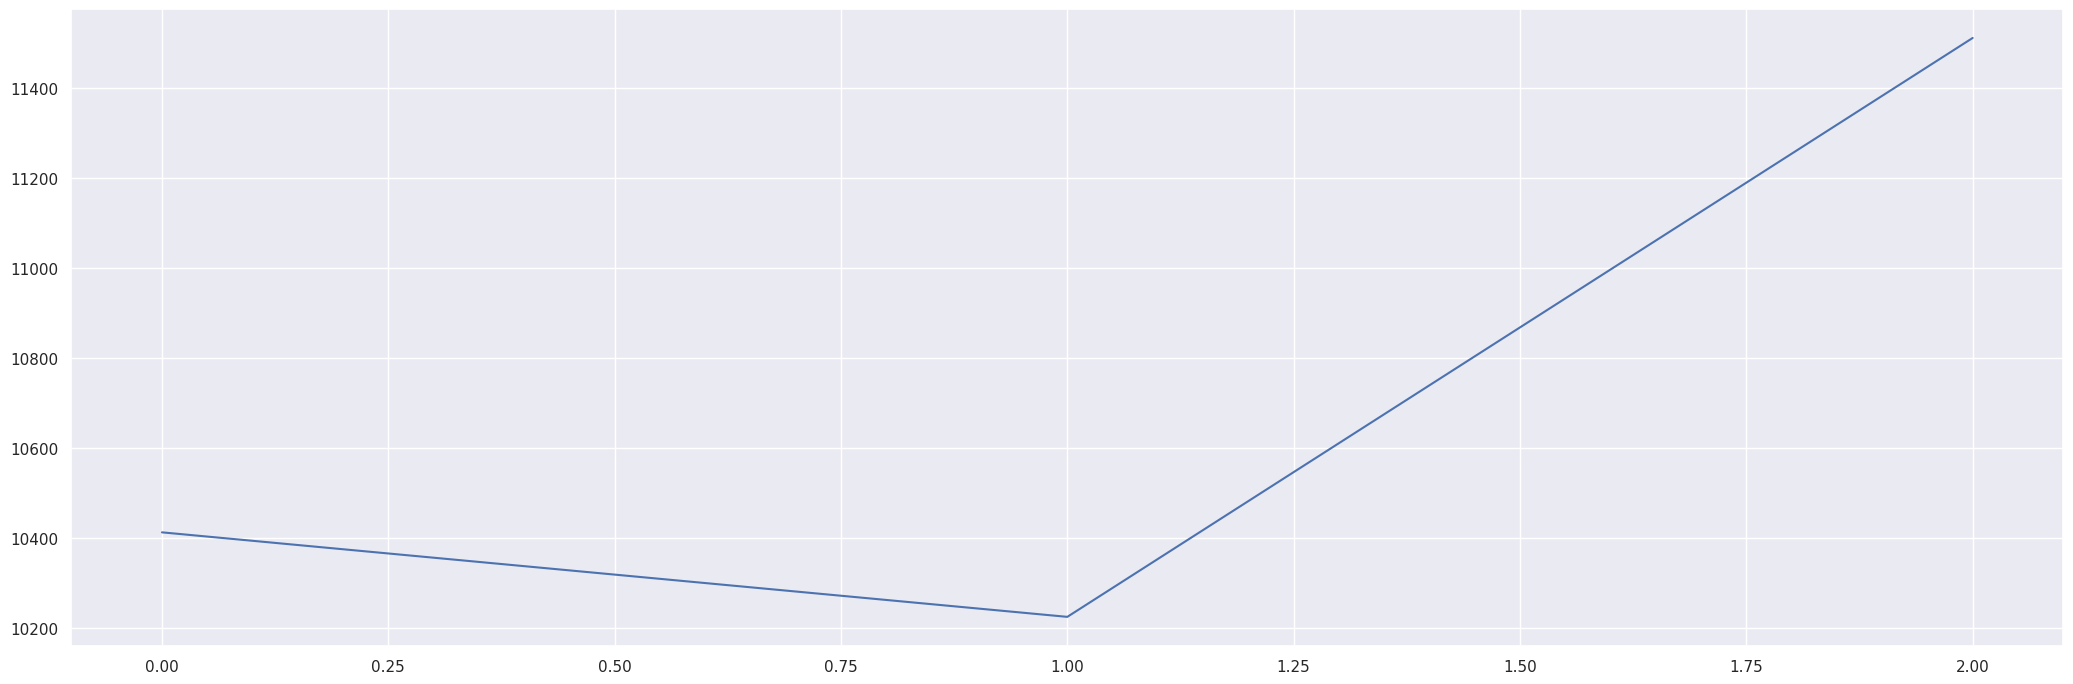

10716.262885729471


In [45]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 15  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1000 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  original_balance = 10000
  current_account = original_balance
  portfolio = {}
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm, cih = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  pp.pprint(portfolio)
  nws.append(networth)
  #plt.plot(pm)
  #plt.show()

print("networth")
plt.plot(nws)
plt.show()
print(sum(nws)/len(nws))

In [ ]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 15  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm, cih = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  pp.pprint(portfolio)
  nws.append(networth)
  #plt.plot(pm)
  #plt.show()

print("networth")
plt.plot(nws)
plt.show()
print(sum(nws)/len(nws))

In [ ]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 1000  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm, cih = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  pp.pprint(portfolio)
  nws.append(networth)
  #plt.plot(pm)
  #plt.show()

print("networth")
plt.plot(nws)
plt.show()
print(sum(nws)/len(nws))

Total networth: 12403 (Cash 1036) after going back 276
{   'ABT': {   'costs': [   99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336],
               'date': Timestamp('2023-03-07 00:00:00-0500', tz='America/New_York'),
               'shares': 5},
    'ALB': {   'costs': [   236.3083038330078,
                            236.3083038330078,
                            236.3083038330078,
                            236.3083038330078,
                            236.3083038330078],
               'date': Timestamp('2023-03-09 00:00:00-0500', tz='America/New_York'),
               'shares': 5},
    'ALLE': {   'costs': [   112.65959930419922,
                             112.65959930419922,
                             112.65959930419922,
                             112.65959930419922,
                             112.65959930419922],
    

Total networth: 12285 (Cash 3188) after going back 220
{   'ABT': {   'costs': [   99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336],
               'date': Timestamp('2023-03-07 00:00:00-0500', tz='America/New_York'),
               'shares': 5},
    'AKAM': {   'costs': [   78.66000366210938,
                             78.66000366210938,
                             78.66000366210938,
                             78.66000366210938,
                             78.66000366210938],
                'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York'),
                'shares': 5},
    'BAX': {   'costs': [   44.84065246582031,
                            44.84065246582031,
                            44.84065246582031,
                            44.84065246582031,
                            44.84065246582031,
        

Total networth: 11468 (Cash 3262) after going back 173
{   'ABT': {   'costs': [   99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336],
               'date': Timestamp('2023-03-07 00:00:00-0500', tz='America/New_York'),
               'shares': 5},
    'AKAM': {   'costs': [   78.66000366210938,
                             78.66000366210938,
                             78.66000366210938,
                             78.66000366210938,
                             78.66000366210938],
                'date': Timestamp('2023-02-15 00:00:00-0500', tz='America/New_York'),
                'shares': 5},
    'BAX': {   'costs': [   44.84065246582031,
                            44.84065246582031,
                            44.84065246582031,
                            44.84065246582031,
                            44.84065246582031,
        

networth


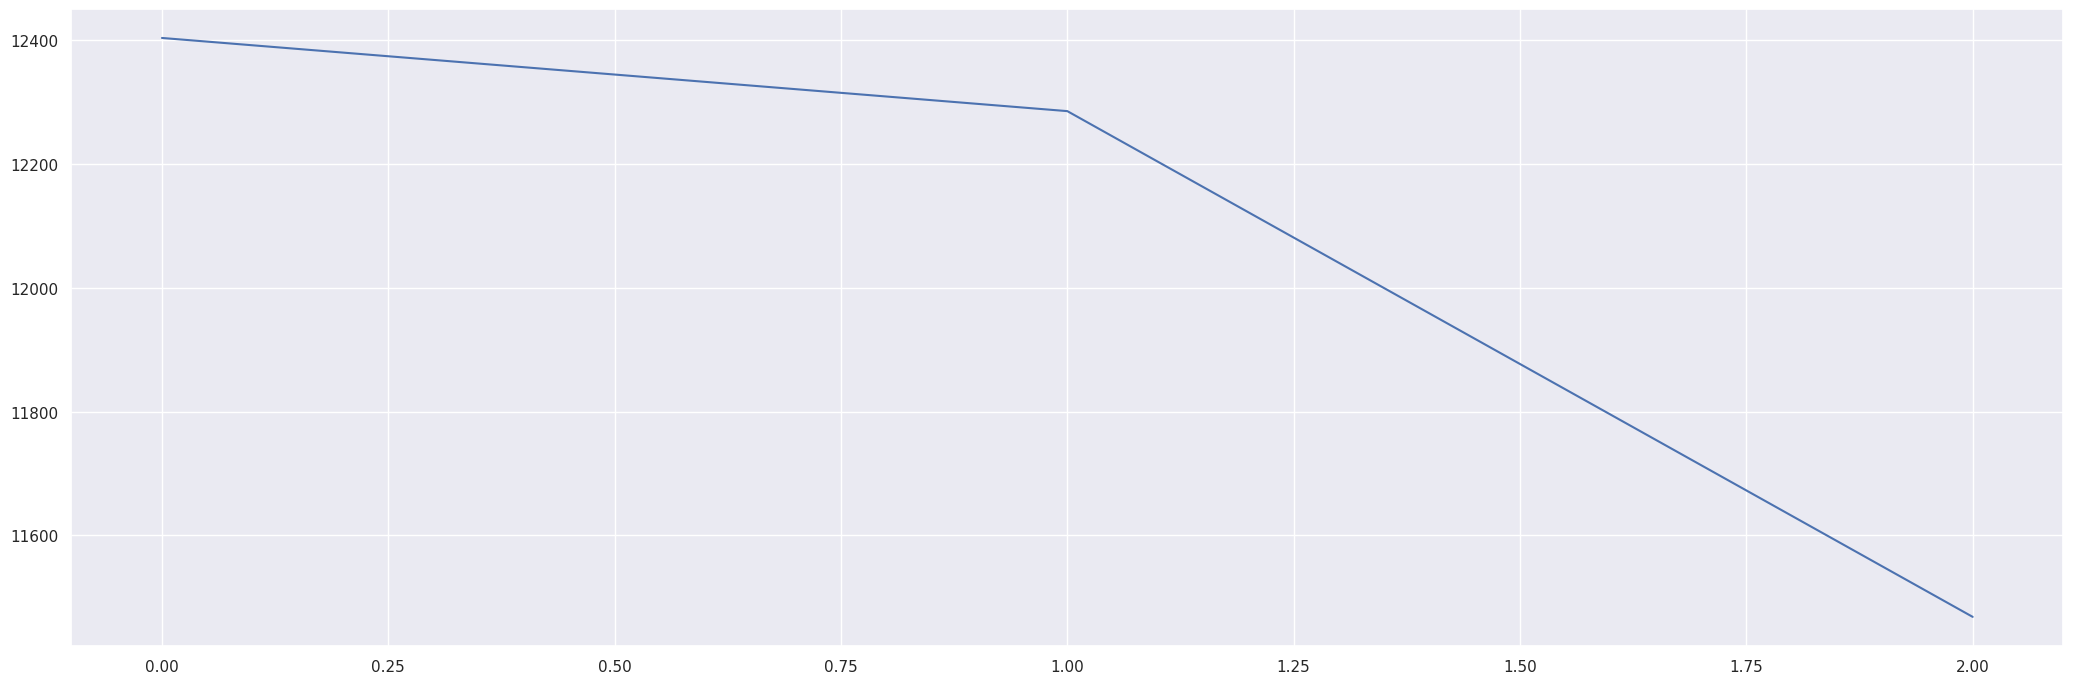

12052.407978375753


In [46]:
import random

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 1000  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

nws = []
for i in range(backtest_iterations):
  tradingdays_togoback = random.randint(100, 300)
  networth, current, pm, cih = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  pp.pprint(portfolio)
  nws.append(networth)
  idx_list = list(indices_ts['^GSPC_Close'])[-tradingdays_togoback:]
  d = pd.DataFrame({'Portfolio_Performance':pm,'SP_Performance':idx_list, "Cash_In_Hand": cih})
  d.index = indices_ts.index[-tradingdays_togoback:]
  pm_pct = (pm[-1]-pm[0])*100/pm[0]
  idx_pct = (idx_list[-1] - idx_list[0])*100/idx_list[0]
  fig = px.line(d, title="Model (%f)%% vs S&P Performance (%f)%%" % (pm_pct, idx_pct), markers=True)
  fig.show()

print("networth")
plt.plot(nws)

plt.show()
print(sum(nws)/len(nws))

Total networth: 10835 (Cash 4013) after going back 208
{   'ABT': {   'costs': [   99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336],
               'date': Timestamp('2023-03-07 00:00:00-0500', tz='America/New_York'),
               'shares': 5},
    'ARE': {   'costs': [   137.47450256347656,
                            137.47450256347656,
                            137.47450256347656,
                            137.47450256347656,
                            137.47450256347656,
                            115.92852020263672,
                            115.92852020263672,
                            115.92852020263672,
                            115.92852020263672,
                            115.92852020263672],
               'date': Timestamp('2023-03-09 00:00:00-0500', tz='America/New_York'),
               'shares': 10},
    

Total networth: 10330 (Cash 3161) after going back 237
{   'ABT': {   'costs': [   99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336],
               'date': Timestamp('2023-03-07 00:00:00-0500', tz='America/New_York'),
               'shares': 5},
    'ALB': {   'costs': [   236.3083038330078,
                            236.3083038330078,
                            236.3083038330078,
                            236.3083038330078,
                            236.3083038330078],
               'date': Timestamp('2023-03-09 00:00:00-0500', tz='America/New_York'),
               'shares': 5},
    'ARE': {   'costs': [   137.47450256347656,
                            137.47450256347656,
                            137.47450256347656,
                            137.47450256347656,
                            137.47450256347656],
         

Total networth: 10330 (Cash 4116) after going back 177
{   'ABT': {   'costs': [   99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336,
                            99.9800033569336],
               'date': Timestamp('2023-03-07 00:00:00-0500', tz='America/New_York'),
               'shares': 5},
    'ALB': {   'costs': [   236.3083038330078,
                            236.3083038330078,
                            236.3083038330078,
                            236.3083038330078,
                            236.3083038330078],
               'date': Timestamp('2023-03-09 00:00:00-0500', tz='America/New_York'),
               'shares': 5},
    'CBRE': {   'costs': [   71.20999908447266,
                             71.20999908447266,
                             71.20999908447266,
                             71.20999908447266,
                             71.20999908447266],
         

networth


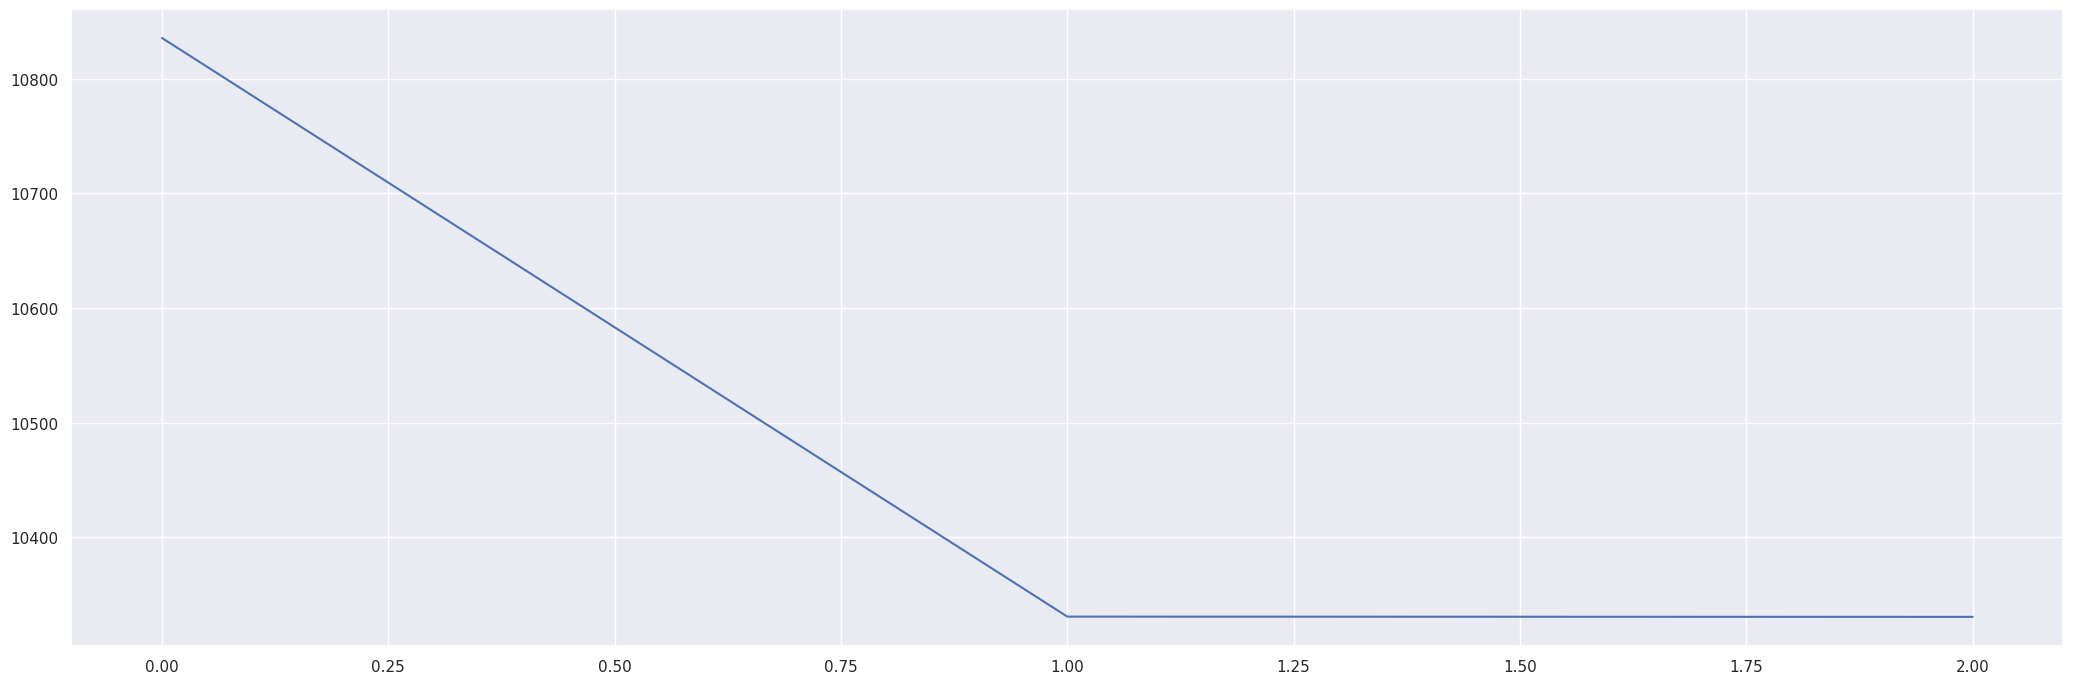

10499.09820397695


In [44]:
import random
import pprint

## Hyper parameters
buy_trigger = 2    # times standard deviation
sell_trigger = 1   # times the avg cost of the security to grow before we sell
security_age = 30  # number of days to hold the security before we cut the losses
lockin_gains_factor = 1.1 # times the orignal amount to grow before we lockin the gains.

pp = pprint.PrettyPrinter(indent=4)

nws = []
for i in range(backtest_iterations):
  tradingdays_togoback = random.randint(100, 400)
  networth, current, pm, cih = do_one_backtesting(tradingdays_togoback)
  print("Total networth: %d (Cash %d) after going back %d" % (networth, current_account, tradingdays_togoback))
  pp.pprint(portfolio)
  nws.append(networth)
  idx_list = list(indices_ts['^GSPC_Close'])[-tradingdays_togoback:]
  d = pd.DataFrame({'Portfolio_Performance':pm,'SP_Performance':idx_list, "Cash_In_Hand": cih})
  d.index = indices_ts.index[-tradingdays_togoback:]
  pm_pct = (pm[-1]-pm[0])*100/pm[0]
  idx_pct = (idx_list[-1] - idx_list[0])*100/idx_list[0]
  fig = px.line(d, title="Model (%f)%% vs S&P Performance (%f)%%" % (pm_pct, idx_pct), markers=True)
  fig.show()

print("networth")
plt.plot(nws)

plt.show()
print(sum(nws)/len(nws))